# Welcome to the Notebook!

## Questions:
1. What type of restaurant is most common? 
2. What type of restaurant has the best reviews?
3. What proportion of restaurants offer delivery?
4. Is there a relationship between number of reviews and review level? 

### Initial Setup

In [2]:
# Import the data manipulation, visualisation and sql libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from pandasql import sqldf

In [4]:
# Import the restaurant data in and country code data
country_codes = pd.read_excel('Country-Code.xlsx')
data = pd.read_csv('zomato.csv', encoding = "ISO-8859-1")
data.head()

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",...,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


In [9]:
# Inner join the data on countries

q = """
    SELECT
        *
    FROM
        data
    JOIN
        country_codes
    ON
        data.[Country Code] = country_codes.[Country Code]
    ;

"""
# Run the SQL query on the original data and look at which countries are in the data
data_with_countries = sqldf(q)
data_with_countries['Country'].value_counts()

India             8652
United States      434
United Kingdom      80
Brazil              60
South Africa        60
UAE                 60
New Zealand         40
Turkey              34
Australia           24
Phillipines         22
Indonesia           21
Sri Lanka           20
Qatar               20
Singapore           20
Canada               4
Name: Country, dtype: int64

Looks like most of the reviews are for Indian restaurants. So we'll restrict analysis to Indian reviews. 
This is because the view on quality may differ amongst countries
Eg. A 5 star review in India may be much better than a 5 star review in the USA

In [10]:
q = """
    SELECT
        *
    FROM 
        data_with_countries
    WHERE
        Country = 'India'
    ;
"""
indian_data = sqldf(q)

### Let's answer question 1! 
What type of restaurant is most common?
The main issue is, the cuisine column has all the possible cuisines a restaurant could be. I will assume that the first entry is the main cuisine of the restaurant and use that in the analysis.

<AxesSubplot:>

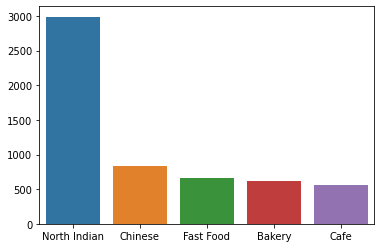

In [25]:
# Map the cuisine column to get the main cuisine
indian_data['Main Cuisine'] = indian_data['Cuisines'].map(lambda x: x.split(",")[0])

#Plot a bar graph showing the number of restaurants for the top 5 cuisines
sns.barplot(x = indian_data['Main Cuisine'].value_counts().head(5).index, y = indian_data['Main Cuisine'].value_counts().head(5).values  )

### Looks like North Indian is most popular followed by Chinese! 
North Indian makes sense as most popular but Chinese as second popular is very interesting! 
The fact South Indian isn't even in the top 5 is also interesting. 

### Let's answer question 2!
What type of restaurant has the best review score on average?

In [46]:
# Create an SQL query to group by main cuisine, then take an average of restaurant aggregate rating for that cuisine
# Only want to chose cuisines which have a reasonable number of restaurants, eg above 100 
# 
q = """
    SELECT 
        [Main Cuisine],
        AVG([Aggregate rating]) AS 'Average Rating'
    FROM 
        indian_data
    GROUP BY
        [Main Cuisine]
    HAVING 
        COUNT([Restaurant ID]) > 100
    ORDER BY
        AVG([Aggregate rating]) DESC
    ;
"""
cuisine_ratings = sqldf(q)

<AxesSubplot:xlabel='Main Cuisine', ylabel='Average Rating'>

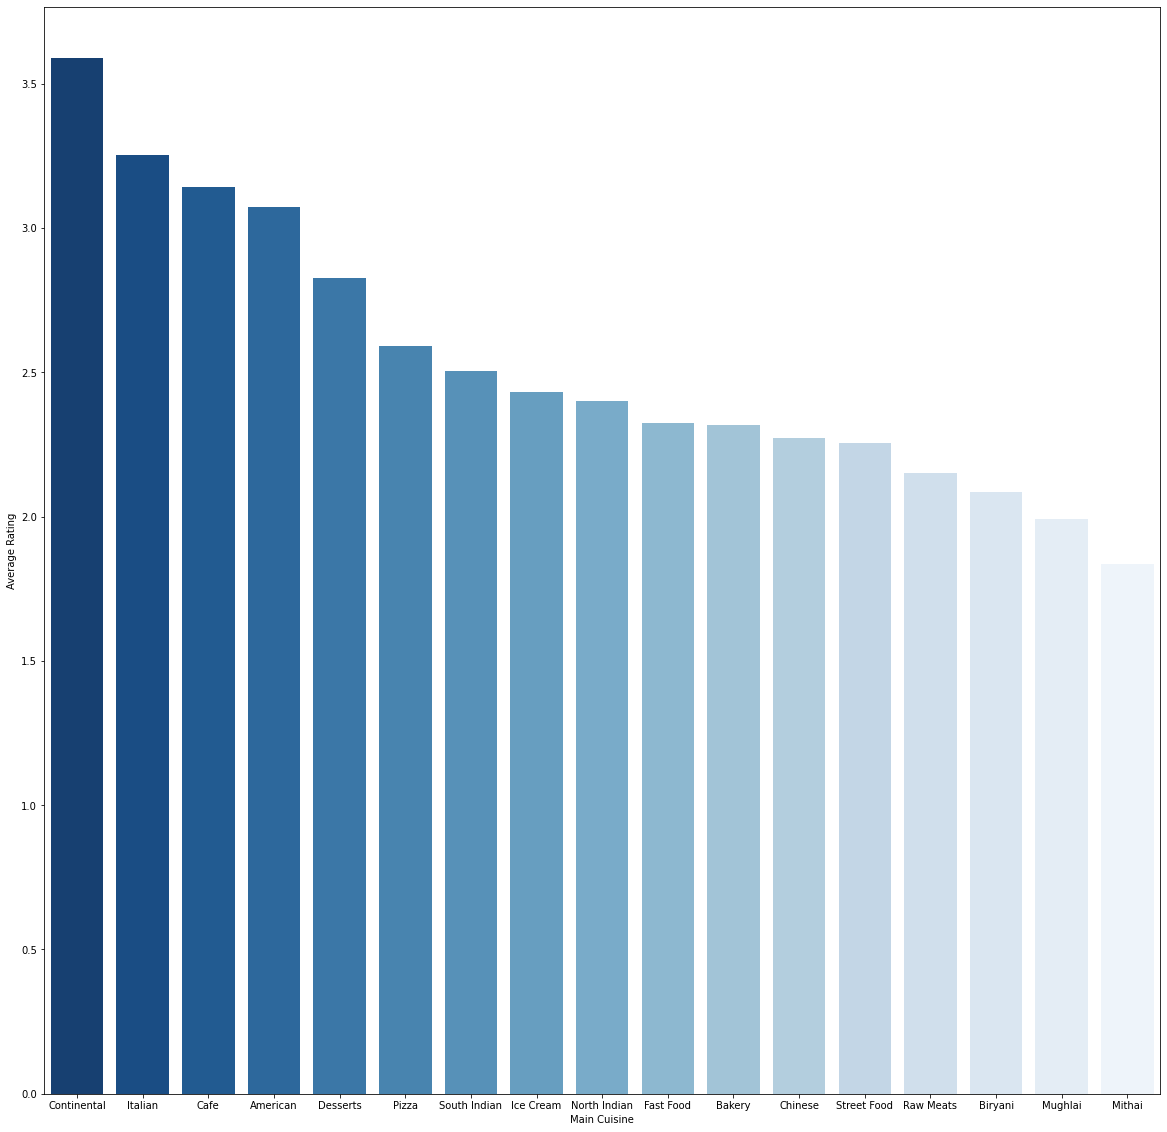

In [55]:
# Let's plot the average rating for the cuisines with over 100 restaurants
plt.figure(figsize = (20,20))
sns.barplot(x = 'Main Cuisine', y = 'Average Rating', data = cuisine_ratings,palette='Blues_r')

### Very Interesting! The cuisine with the best average reviews is Continental Food. 
This food is specialty food on the continent of Europe, from countries such as France and Spain. Interesting that this food is known for being lighter on spices in contrast to Indian food which is very spice heavy.

### Question 3: What proportion of restaurants deliver?
This is going to require a bit of data munging to map 'Yes' or 'No' to a dummy variable

<AxesSubplot:ylabel='Has Online delivery'>

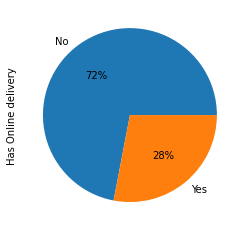

In [73]:
indian_data['Has Online delivery'].value_counts().plot.pie(autopct="%.0f%%")

Looks like most don't actually have online delivery! Surprising